In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_feather('../../dataset/preprocessed_data.feather')[['user_id', 'product_id', 'event_type', 'category_code', 'brand']]
df.head()

,user_id,product_id,event_type,category_code,brand
0,541312140,44600062,view,#unknown,shiseido
1,554748717,3900821,view,appliances.environment.water_heater,aqua
2,519107250,17200506,view,furniture.living_room.sofa,#unknown
3,550050854,1307067,view,computers.notebook,lenovo
4,535871217,1004237,view,electronics.smartphone,apple


In [3]:
df['event_weight'] = df['event_type'].map(
    {
        'view': 1,
        'cart': 2,
        'purchase': 3,
    }
)

df.head()

,user_id,product_id,event_type,category_code,brand,event_weight
0,541312140,44600062,view,#unknown,shiseido,1
1,554748717,3900821,view,appliances.environment.water_heater,aqua,1
2,519107250,17200506,view,furniture.living_room.sofa,#unknown,1
3,550050854,1307067,view,computers.notebook,lenovo,1
4,535871217,1004237,view,electronics.smartphone,apple,1


In [4]:
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)
print(f'train: {len(train_df)}, test: {len(test_df)}')
del df

train: 38203885, test: 4244877


In [5]:
user_counts = train_df['user_id'].value_counts().reset_index()[['user_id', 'count']]
product_counts = train_df['product_id'].value_counts().reset_index()[['product_id', 'count']]

unique_user_ids = user_counts[user_counts['count'] >= 10]['user_id']
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
user_index_to_id = {index: user_id for index, user_id in enumerate(unique_user_ids)}

unique_product_ids = product_counts[product_counts['count'] >= 10]['product_id']
product_id_to_index = {product_id: index for index, product_id in enumerate(unique_product_ids)}
product_index_to_id = {index: product_id for index, product_id in enumerate(unique_product_ids)}

del user_counts, product_counts

train_df = train_df[
    (train_df['user_id'].isin(unique_user_ids)) & 
    (train_df['product_id'].isin(unique_product_ids))
]

test_df = test_df[
    (test_df['user_id'].isin(unique_user_ids)) & 
    (test_df['product_id'].isin(unique_product_ids))
]

print(f'unique user ids: {len(unique_user_ids)}')
print(f'unique product ids: {len(unique_product_ids)}')
print(f'train: {len(train_df)}, test: {len(test_df)}')

unique user ids: 890624
unique product ids: 111230
train: 31907671, test: 2237552


In [6]:
train_df['user_index'] = [user_id_to_index[user_id] for user_id in train_df['user_id']]
train_df['product_index'] = [product_id_to_index[product_id] for product_id in train_df['product_id']]

test_df['user_index'] = [user_id_to_index[user_id] for user_id in test_df['user_id']]
test_df['product_index'] = [product_id_to_index[product_id] for product_id in test_df['product_id']]

In [7]:
# 사용자-아이템 상호작용 행렬 생성
train_matrix = csr_matrix((train_df['event_weight'], (train_df['user_index'], train_df['product_index'])))
test_matrix = csr_matrix((test_df['event_weight'], (test_df['user_index'], test_df['product_index'])))

In [8]:
# ALS 모델 초기화 및 훈련
model = AlternatingLeastSquares(
    factors=50,
    regularization=0.01,
    iterations=30,
    random_state=42,
    calculate_training_loss=True,
)
model.fit(train_matrix, show_progress=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
def recommend_all(n_sample_users=10000):
    sample_user_indices = test_df['user_index'].unique().tolist()[:n_sample_users]
    product_indices_list, _ = model.recommend(sample_user_indices, train_matrix[sample_user_indices], N=500)

    recommendations_dict = {}
    for user_index, product_indices in zip(sample_user_indices, product_indices_list):
        recommendations_dict[user_index_to_id[user_index]] = [product_index_to_id[i] for i in product_indices]

    return recommendations_dict

recommendations_dict = recommend_all()

In [10]:
interaction_dict = test_df.groupby('user_id')['product_id'].agg(lambda x: list(set(x))).to_dict()

In [11]:
def calculate_metrics(topk=10):

    total_users = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0

    for user_id in tqdm(interaction_dict.keys()):
        if user_id not in recommendations_dict:
            continue

        true_items = set(interaction_dict[user_id])
        recommended_items = recommendations_dict[user_id]
        top_k_items = set(recommended_items[:topk])

        # precision
        precision = len(top_k_items & true_items) / len(recommended_items)
        precision_sum += precision
        
        # recall
        recall = len(top_k_items & true_items) / len(true_items)
        recall_sum += recall

        # NDCG
        dcg = 0
        idcg = 0
        for i, item in enumerate(top_k_items):
            rel = 1 if item in true_items else 0
            dcg += (2**rel - 1) / np.log2(i + 2)
        
        ideal_ranking = sorted([1 if item in true_items else 0 for item in top_k_items], reverse=True)
        for i, rel in enumerate(ideal_ranking):
            idcg += (2**rel - 1) / np.log2(i + 2)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_sum += ndcg

        total_users += 1
        
    mean_precision = precision_sum / total_users
    mean_recall = recall_sum / total_users
    mean_ndcg = float(ndcg_sum / total_users)

    return mean_precision, mean_recall, mean_ndcg

In [12]:
topk_values = [10, 30, 50, 100, 200, 300, 400, 500]

precisions, recalls, ndcgs = [], [], []
for topk in topk_values:
    precision, recall, ndcg = calculate_metrics(topk=topk)
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    print(f'precision@{topk}: {precision:.5f}, recall@{topk}: {recall:.5f}, ndcg@{topk}: {ndcg:.5f}')

100%|██████████| 201351/201351 [00:00<00:00, 911767.42it/s]


precision@10: 0.00055, recall@10: 0.03771, ndcg@10: 0.09244


100%|██████████| 201351/201351 [00:00<00:00, 416450.01it/s]


precision@30: 0.00114, recall@30: 0.07224, ndcg@30: 0.10089


100%|██████████| 201351/201351 [00:00<00:00, 261169.48it/s]


precision@50: 0.00153, recall@50: 0.09420, ndcg@50: 0.10339


100%|██████████| 201351/201351 [00:01<00:00, 134116.05it/s]


precision@100: 0.00215, recall@100: 0.12507, ndcg@100: 0.10490


100%|██████████| 201351/201351 [00:02<00:00, 67593.99it/s]


precision@200: 0.00292, recall@200: 0.16348, ndcg@200: 0.10734


100%|██████████| 201351/201351 [00:04<00:00, 41566.80it/s]


precision@300: 0.00341, recall@300: 0.18687, ndcg@300: 0.10770


100%|██████████| 201351/201351 [00:06<00:00, 33286.00it/s]


precision@400: 0.00379, recall@400: 0.20431, ndcg@400: 0.10507


100%|██████████| 201351/201351 [00:07<00:00, 25179.83it/s]

precision@500: 0.00410, recall@500: 0.21813, ndcg@500: 0.10574


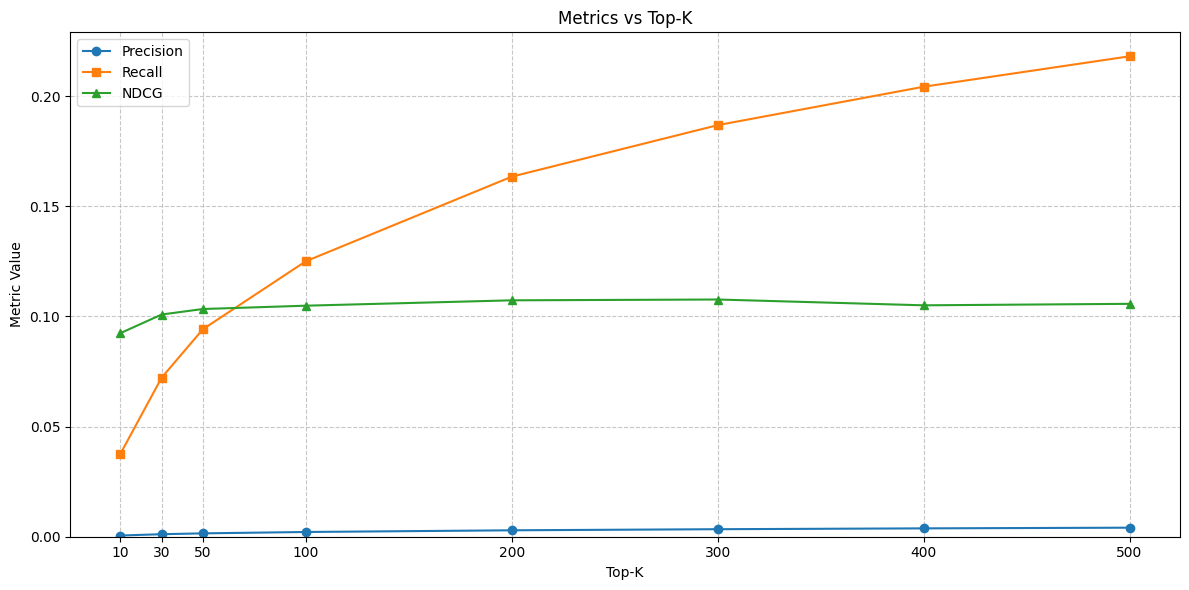

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(topk_values, precisions, marker='o', label='Precision')

plt.plot(topk_values, recalls, marker='s', label='Recall')

plt.plot(topk_values, ndcgs, marker='^', label='NDCG')

plt.title('Metrics vs Top-K')
plt.xlabel('Top-K')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(topk_values)

plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

In [26]:
import random

random_user_id = random.choice(list(recommendations_dict.keys()))
print(random_user_id)

train_df[train_df['user_id'] == random_user_id]

534006498


,user_id,product_id,event_type,category_code,brand,event_weight,user_index,product_index
1079098,534006498,5700922,view,auto.accessories.player,#unknown,1,149282,2728
1080846,534006498,5700922,view,auto.accessories.player,#unknown,1,149282,2728
3152881,534006498,1004950,view,electronics.smartphone,oneplus,1,149282,2126
3153089,534006498,1003898,view,electronics.smartphone,oneplus,1,149282,1899
3153657,534006498,1003898,view,electronics.smartphone,oneplus,1,149282,1899
7151497,534006498,5700922,view,auto.accessories.player,#unknown,1,149282,2728
7152442,534006498,5700922,view,auto.accessories.player,#unknown,1,149282,2728
8812072,534006498,5700922,view,auto.accessories.player,#unknown,1,149282,2728
8812157,534006498,5700922,view,auto.accessories.player,#unknown,1,149282,2728
8812245,534006498,5701149,view,auto.accessories.player,#unknown,1,149282,1371


In [27]:
recommend_product_ids = recommendations_dict[random_user_id]
recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
    lambda x: tuple(x[['category_code', 'brand']].iloc[0])
).to_dict()

for product_id in recommend_product_ids[:10]:
    category_code, brand = recommend_product_dict[product_id]
    print(category_code, brand)

auto.accessories.player #unknown
auto.accessories.alarm starline
electronics.smartphone samsung
auto.accessories.player #unknown
#unknown triangle
#unknown cordiant
auto.accessories.videoregister sho-me
auto.accessories.alarm starline
auto.accessories.videoregister #unknown
#unknown cordiant


/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_46454/1646290948.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
